In [ ]:
# Notebook initialization for consistent paths (repo-aware)
import os, sys, pathlib

# Resolve repo root by walking up until we find 'src'
CWD = pathlib.Path.cwd()
ROOT = CWD
for _ in range(6):
    if (ROOT / 'src').exists():
        break
    ROOT = ROOT.parent
# Fallback to current if not found
if not (ROOT / 'src').exists():
    ROOT = CWD

PROJECT_ROOT = ROOT.resolve()
PROJECT_SRC = PROJECT_ROOT / 'src'
DATA_DIR = PROJECT_SRC / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

if str(PROJECT_SRC) not in sys.path:
    sys.path.insert(0, str(PROJECT_SRC))

print(f'PROJECT_ROOT={PROJECT_ROOT}')
print(f'PROJECT_SRC={PROJECT_SRC}')
print(f'RAW_DATA_DIR={RAW_DATA_DIR}')
print(f'PROCESSED_DATA_DIR={PROCESSED_DATA_DIR}')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings   
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb


device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
torch.manual_seed(42)
print(xgb.__version__)

2.0.3


In [ ]:
# Embedding file paths

# Hybrid:
# emb_value_file = f"{PROCESSED_DATA_DIR}/hybrid_embeddings.npy"
# label_file =f"{PROCESSED_DATA_DIR}/hybrid_labels.npy"

# Text only:
emb_value_file = f"{PROCESSED_DATA_DIR}/text_only_embeddings.npy"
label_file =f"{PROCESSED_DATA_DIR}/text_only_labels.npy"




Using device: mps


In [ ]:
# MLP Architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 1) # Output layer for binary classification
        )

    def forward(self, x):
        return self.layers(x)

In [4]:
# Open disk-backed arrays
X_flat = np.memmap(emb_value_file, dtype='float32', mode='r')
y_mmap = np.load(label_file, mmap_mode='r')
N = y_mmap.shape[0]; D = X_flat.shape[0] // N
X_mmap = X_flat.reshape(N, D)
print("Disk-backed:", X_mmap.shape, X_mmap.dtype)

# Stratified index-only splits (no feature copies)
all_idx = np.arange(N, dtype=np.int64)
trainval_idx, test_idx = train_test_split(all_idx, test_size=0.20, stratify=y_mmap, random_state=42)
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.20, stratify=y_mmap[trainval_idx], random_state=42)

# pos_weight from train labels subset
y_tr = y_mmap[train_idx]
num_pos = int((y_tr == 1).sum()); num_neg = int((y_tr == 0).sum())
pos_weight = torch.tensor([num_neg / max(1, num_pos)], device=device, dtype=torch.float32)

class MemmapDataset(Dataset):
    def __init__(self, X, y, indices):
        self.X, self.y = X, y
        self.indices = np.asarray(indices, dtype=np.int64)
    def __len__(self): return self.indices.shape[0]
    def __getitem__(self, idx):
        i = int(self.indices[idx])
        x = np.asarray(self.X[i], dtype=np.float32)
        y = float(self.y[i])
        return torch.from_numpy(x), torch.tensor([y], dtype=torch.float32)

train_dataset = MemmapDataset(X_mmap, y_mmap, train_idx)
val_dataset   = MemmapDataset(X_mmap, y_mmap, val_idx)
test_dataset  = MemmapDataset(X_mmap, y_mmap, test_idx)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True,  num_workers=0, pin_memory=False)
validate_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset,   batch_size=256, shuffle=False, num_workers=0, pin_memory=False)

model = MLP(input_size=D).to(device)

# Calculate pos_weight: count_negative / count_positive
y_tr = np.asarray(y_mmap[train_idx], dtype=np.int64)
num_pos = int((y_tr == 1).sum())
num_neg = int(y_tr.size - num_pos)  # or int((y_tr == 0).sum())
pos_weight = torch.tensor([num_neg / max(1, num_pos)], device=device, dtype=torch.float32)
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

print("DataLoaders prepared.")
print("\n" + "="*50 + "\n")

Disk-backed: (1369565, 5760) float32
DataLoaders prepared.




In [5]:
# Training loop
epochs = 100

# Early Stopping Parameters
patience = 6
patience_counter = 0
best_loss = np.inf

for epoch in range(epochs):
    # Training Phase
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

    # Validation Phase
    model.eval()
    current_val_loss = 0
    with torch.no_grad():
        for images, labels in validate_loader:
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = model(images)
            loss = loss_function(outputs, labels)
            current_val_loss += loss.item()

    avg_val_loss = current_val_loss / len(validate_loader)
    print(f"Epoch {epoch+1}/{epochs} | Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_loss:
        torch.save(model.state_dict(), 'Final_MLP_model.pth')
        best_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("--- Training Finished ---")

Epoch 1/100 | Batch 0/3424 | Loss: 1.1325
Epoch 1/100 | Batch 100/3424 | Loss: 0.9167
Epoch 1/100 | Batch 200/3424 | Loss: 0.9964
Epoch 1/100 | Batch 300/3424 | Loss: 1.0818
Epoch 1/100 | Batch 400/3424 | Loss: 0.9955
Epoch 1/100 | Batch 500/3424 | Loss: 1.0366
Epoch 1/100 | Batch 600/3424 | Loss: 0.9908
Epoch 1/100 | Batch 700/3424 | Loss: 0.8962
Epoch 1/100 | Batch 800/3424 | Loss: 0.9053
Epoch 1/100 | Batch 900/3424 | Loss: 0.9427
Epoch 1/100 | Batch 1000/3424 | Loss: 0.9974
Epoch 1/100 | Batch 1100/3424 | Loss: 0.8815
Epoch 1/100 | Batch 1200/3424 | Loss: 1.0025
Epoch 1/100 | Batch 1300/3424 | Loss: 0.8883
Epoch 1/100 | Batch 1400/3424 | Loss: 0.9723
Epoch 1/100 | Batch 1500/3424 | Loss: 0.9659
Epoch 1/100 | Batch 1600/3424 | Loss: 1.0180
Epoch 1/100 | Batch 1700/3424 | Loss: 0.9843
Epoch 1/100 | Batch 1800/3424 | Loss: 0.8853
Epoch 1/100 | Batch 1900/3424 | Loss: 0.9925
Epoch 1/100 | Batch 2000/3424 | Loss: 0.9481
Epoch 1/100 | Batch 2100/3424 | Loss: 1.0087
Epoch 1/100 | Batch 22

Evaluating Model Performance on Test Set...

**=== Calculating Optimal Threshold ===**
Best Threshold found: 0.5059

--- Final Classification Report (Optimal Threshold) ---
              precision    recall  f1-score   support

           0       0.88      0.64      0.74    215748
           1       0.34      0.67      0.45     58165

    accuracy                           0.65    273913
   macro avg       0.61      0.66      0.60    273913
weighted avg       0.76      0.65      0.68    273913

ROC AUC Score: 0.7183

--- Final Confusion Matrix ---


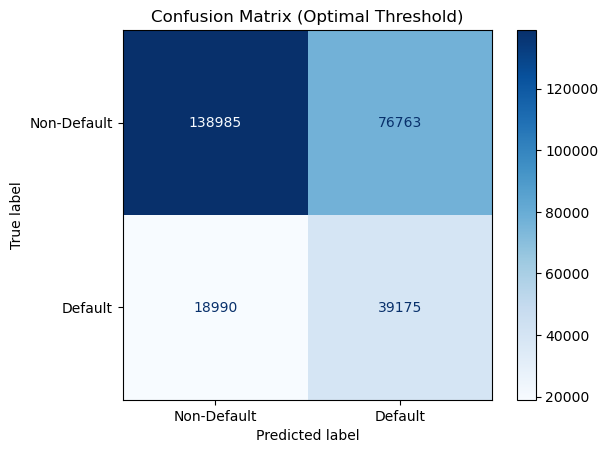

Accuracy : 0.6504255000675397
Recall    : 0.6735150004298117
Precision : 0.33789611689006194
F1-score  : 0.4500209646014141
ROC-AUC   : 0.7183029367093494

--- Model Evaluation Complete ---

--- Final Classification Report (Stale Threshold) ---
              precision    recall  f1-score   support

           0       0.88      0.63      0.74    215748
           1       0.33      0.68      0.45     58165

    accuracy                           0.64    273913
   macro avg       0.61      0.66      0.59    273913
weighted avg       0.77      0.64      0.68    273913

ROC AUC Score: 0.7183

--- Final Confusion Matrix ---


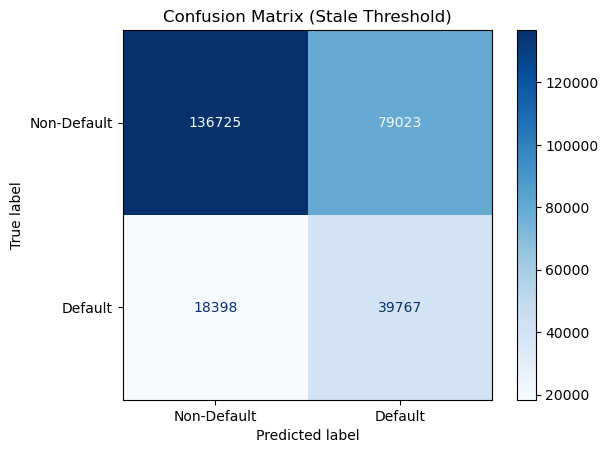

Accuracy : 0.6443359752914246
Recall    : 0.6836929424911888
Precision : 0.3347672362993518
F1-score  : 0.4494589019807296
ROC-AUC   : 0.7183029367093494

--- Model Evaluation Complete ---


In [6]:

# --- 1. Load Best Model and Get Predictions ---
print("Evaluating Model Performance on Test Set...")

# Load the weights from your best epoch
# This assumes your model variable is already defined (e.g., model = MLP(...))
model.load_state_dict(torch.load('Final_MLP_model.pth'))
model.to(device) # Ensure model is on the correct device
model.eval()

y_true = np.asarray(y_mmap[test_idx], dtype=np.int32)
y_test = y_true

# Collect the model's predicted probabilities for the test set
y_prob_list = []
with torch.no_grad():
    for data, _ in test_loader:
        # Use the general `device` variable for robustness
        data = data.to(device)
        
        logits = model(data)
        probs = torch.sigmoid(logits)
        y_prob_list.append(probs.cpu().numpy())

# Concatenate the probabilities from all batches into a single array
y_prob = np.concatenate(y_prob_list).ravel()


# --- 2. Find Optimal Threshold and Make Final Predictions ---
print("\n**=== Calculating Optimal Threshold ===**")

# Use y_test (from your train_test_split) as the ground truth
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Calculate F1 score for each threshold to find the best balance
# Add a small epsilon (1e-9) to avoid division by zero
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# Get the best threshold
best_threshold_idx = np.argmax(f1_scores[:-1]) # Exclude the last value
best_threshold = thresholds[best_threshold_idx]
print(f"Best Threshold found: {best_threshold:.4f}")

# Apply the best threshold to get your final predictions
y_pred = (y_prob >= best_threshold).astype(int)


# --- 3. Display Final Results ---
print("\n--- Final Classification Report (Optimal Threshold) ---")

# Print the full report
print(classification_report(y_test, y_pred))

# Print the final ROC AUC score (uses probabilities)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Display the final confusion matrix
print("\n--- Final Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=["Non-Default", "Default"]).plot(
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix (Optimal Threshold)")
plt.show()
# Metrics
print("Accuracy :", accuracy_score (y_test, y_pred))
print("Recall    :", recall_score    (y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred))
print("F1-score  :", f1_score       (y_test, y_pred))
print("ROC-AUC   :", roc_auc_score  (y_test, y_prob))
print("\n--- Model Evaluation Complete ---")



y_pred = (y_prob >= 0.5).astype(int)


# --- 3. Display Final Results ---
print("\n--- Final Classification Report (Stale Threshold) ---")

# Print the full report
print(classification_report(y_test, y_pred))

# Print the final ROC AUC score (uses probabilities)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Display the final confusion matrix
print("\n--- Final Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=["Non-Default", "Default"]).plot(
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix (Stale Threshold)")
plt.show()
# Metrics
print("Accuracy :", accuracy_score (y_test, y_pred))
print("Recall    :", recall_score    (y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred))
print("F1-score  :", f1_score       (y_test, y_pred))
print("ROC-AUC   :", roc_auc_score  (y_test, y_prob))
print("\n--- Model Evaluation Complete ---")

In [5]:
def write_split_to_csv(X_mmap, y_mmap, indices, filename, chunk_size=20000):
    """
    Reads data from memmap arrays in chunks using a list of indices
    and writes it to a CSV file. The label is the first column.
    """
    print(f"Writing {len(indices)} rows to '{filename}'...")
    
    # If file exists, remove it to start fresh
    if os.path.exists(filename):
        os.remove(filename)

    num_chunks = (len(indices) + chunk_size - 1) // chunk_size  # Ceiling division

    for i, chunk_start in enumerate(range(0, len(indices), chunk_size)):
        chunk_end = min(chunk_start + chunk_size, len(indices))
        index_chunk = indices[chunk_start:chunk_end]

        # This is the memory-critical step, but it's only a small, manageable chunk
        X_chunk = np.asarray(X_mmap[index_chunk])
        y_chunk = np.asarray(y_mmap[index_chunk]).reshape(-1, 1)

        # Combine label and features (label as first column)
        combined_chunk = np.hstack([y_chunk, X_chunk])

        # Append the chunk to the file
        with open(filename, 'ab') as f:  # 'ab' is append binary mode
            np.savetxt(f, combined_chunk, delimiter=',', fmt='%f')

        # Progress update
        print(f"  ... Wrote chunk {i+1}/{num_chunks}", end='\r')
    
    print(f"\n✅ Finished writing to '{filename}'.")


# --- Assuming your variables are already loaded ---
# X_mmap, y_mmap, train_idx, val_idx are available from your previous code

# --- Execute the writing process ---
# This is a one-time operation per dataset split

# write_split_to_csv(X_mmap, y_mmap, train_idx, 'train_xgboost2.csv')
# write_split_to_csv(X_mmap, y_mmap, val_idx, 'validation_xgboost2.csv')
# write_split_to_csv(X_mmap, y_mmap, test_idx, 'test_xgboost2.csv')

In [6]:
y_tr = y_mmap[train_idx]
num_neg = (y_tr == 0).sum()
num_pos = (y_tr == 1).sum()
scale_pos_weight = num_neg / max(1, num_pos)
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

# --- Point DMatrix to the files on disk ---
# The format is: 'filename?format=csv&label_column=0#cache_filename'
# - ?format=csv: Tells XGBoost it's a CSV.
# - &label_column=0: Tells XGBoost the first column is the target variable.
# - #dtrain.cache: The name for the binary cache file XGBoost will create.
uri_train = 'train_xgboost.csv?format=csv&label_column=0#dtrain.cache'
uri_val = 'validation_xgboost.csv?format=csv&label_column=0#dval.cache'
uri_test = 'test_xgboost.csv?format=csv&label_column=0#dtest.cache'

print("Creating DMatrix objects from files...")
dtrain = xgb.DMatrix(uri_train)
dval = xgb.DMatrix(uri_val)
dtest = xgb.DMatrix(uri_test)

print("DMatrix objects created for out-of-core training.")

params = {
    "objective": "binary:logistic",
    "tree_method": "hist",
    "eta": 0.07,
    "max_depth": 3,
    "subsample": 0.9,
    "colsample_bytree": 0.6,
    "lambda": 1.0,
    "alpha": 0.0,
    "scale_pos_weight": scale_pos_weight,
    "eval_metric": ["logloss","auc"],
    "max_bin": 64,  # Default is 256. Lower this to reduce memory usage.
    "seed": 42,
}

print("Training XGBoost model...")
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dval, 'validation')],
    early_stopping_rounds=50,
    verbose_eval=10 # Optional: prints progress every 25 rounds
)
print("✅ Training complete.")

# The trained model is in the 'booster' key of the output
predictions = bst.predict(dtest)


Scale Pos Weight: 3.71
Creating DMatrix objects from files...
DMatrix objects created for out-of-core training.
Training XGBoost model...
[0]	validation-logloss:0.68610	validation-auc:0.67977
[10]	validation-logloss:0.65052	validation-auc:0.68933
[20]	validation-logloss:0.63974	validation-auc:0.69253
[30]	validation-logloss:0.63514	validation-auc:0.69580
[40]	validation-logloss:0.63226	validation-auc:0.69913
[50]	validation-logloss:0.63023	validation-auc:0.70181
[60]	validation-logloss:0.62866	validation-auc:0.70384
[70]	validation-logloss:0.62735	validation-auc:0.70534
[80]	validation-logloss:0.62619	validation-auc:0.70676
[90]	validation-logloss:0.62529	validation-auc:0.70793
[100]	validation-logloss:0.62444	validation-auc:0.70895
[110]	validation-logloss:0.62369	validation-auc:0.70985
[120]	validation-logloss:0.62308	validation-auc:0.71068
[130]	validation-logloss:0.62249	validation-auc:0.71135
[140]	validation-logloss:0.62198	validation-auc:0.71194
[150]	validation-logloss:0.62152	


[XGB] Best Threshold found: 0.5246

--- XGBoost Classification Report (Optimal Threshold) ---
              precision    recall  f1-score   support

           0       0.87      0.68      0.77    215748
           1       0.35      0.64      0.45     58165

    accuracy                           0.67    273913
   macro avg       0.61      0.66      0.61    273913
weighted avg       0.76      0.67      0.70    273913

ROC AUC Score: 0.7209


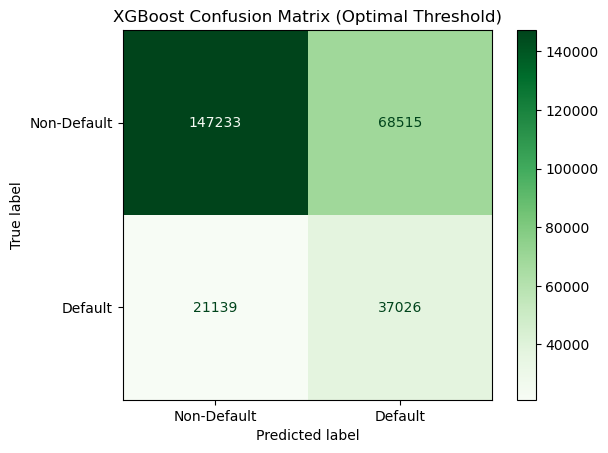


--- XGBoost Classification Report (0.5 Threshold) ---
              precision    recall  f1-score   support

           0       0.88      0.64      0.74    215748
           1       0.34      0.68      0.45     58165

    accuracy                           0.65    273913
   macro avg       0.61      0.66      0.60    273913
weighted avg       0.77      0.65      0.68    273913

ROC AUC Score: 0.7209


In [7]:
bst.save_model("Final_XGB_text_only_model.json")
# later
# bst2 = xgb.Booster()
# bst2.load_model("Final_XGB_text_only_model.json")

# Eval
y_te = np.asarray(y_mmap[test_idx], dtype=np.int32)
p = bst.predict(dtest)

# Predict with best iteration if early stopping was used
best_iter = getattr(bst, "best_iteration", None)
xgb_prob = bst.predict(dtest, iteration_range=(0, best_iter + 1)) if best_iter is not None else bst.predict(dtest)

# Optimal threshold by F1
prec, rec, thr = precision_recall_curve(y_te, xgb_prob)
f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-9)
best_thr = thr[np.argmax(f1s)]
print(f"\n[XGB] Best Threshold found: {best_thr:.4f}")

# Reports
xgb_pred = (xgb_prob >= best_thr).astype(int)
print("\n--- XGBoost Classification Report (Optimal Threshold) ---")
print(classification_report(y_te, xgb_pred))
print(f"ROC AUC Score: {roc_auc_score(y_te, xgb_prob):.4f}")

cm = confusion_matrix(y_te, xgb_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=["Non-Default", "Default"]).plot(cmap="Greens", values_format="d")
plt.title("XGBoost Confusion Matrix (Optimal Threshold)")
plt.show()

# Also show 0.5 threshold
xgb_pred05 = (xgb_prob >= 0.5).astype(int)
print("\n--- XGBoost Classification Report (0.5 Threshold) ---")
print(classification_report(y_te, xgb_pred05))
print(f"ROC AUC Score: {roc_auc_score(y_te, xgb_prob):.4f}")